# AR/MA

In [1]:
import ts_utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# EDA: Exploratory Data Analysis

In [6]:
# pip install gcsfs
uri = "gs://resources-gdm/weather.csv"
weather = pd.read_csv(uri, index_col=0)

In [7]:
# Los índices son strings
weather.index.dtype

dtype('O')

In [8]:
# Hacemos un "casting" de strings a fechas
weather.index = pd.to_datetime(weather.index)
weather.index.dtype

dtype('<M8[ns]')

In [9]:
weather.dtypes

dia             int64
mes             int64
anno            int64
temp_max      float64
temp_min      float64
temp_media    float64
htemp_max      object
htemp_min      object
hum_max       float64
hum_min       float64
hhum_max       object
hhum_min       object
pres_max      float64
pres_min      float64
pres_media    float64
hpres_max      object
hpres_min      object
rad_max       float64
rad_min       float64
hrad_max      float64
hrad_min      float64
vv_max        float64
vv_media      float64
rachas_max    float64
hvv_max        object
lluvia        float64
dtype: object

In [10]:
# min_x f(x)
weather["temp_media"].min()

15.0

In [11]:
# arg min_x f(x)
weather["temp_media"].idxmin()

Timestamp('1989-12-24 00:00:00')

In [12]:
# max_x f(x)
weather["temp_media"].max()

36.0

In [13]:
# arg max_x f(x)
weather["temp_media"].idxmax()

Timestamp('1982-05-28 00:00:00')

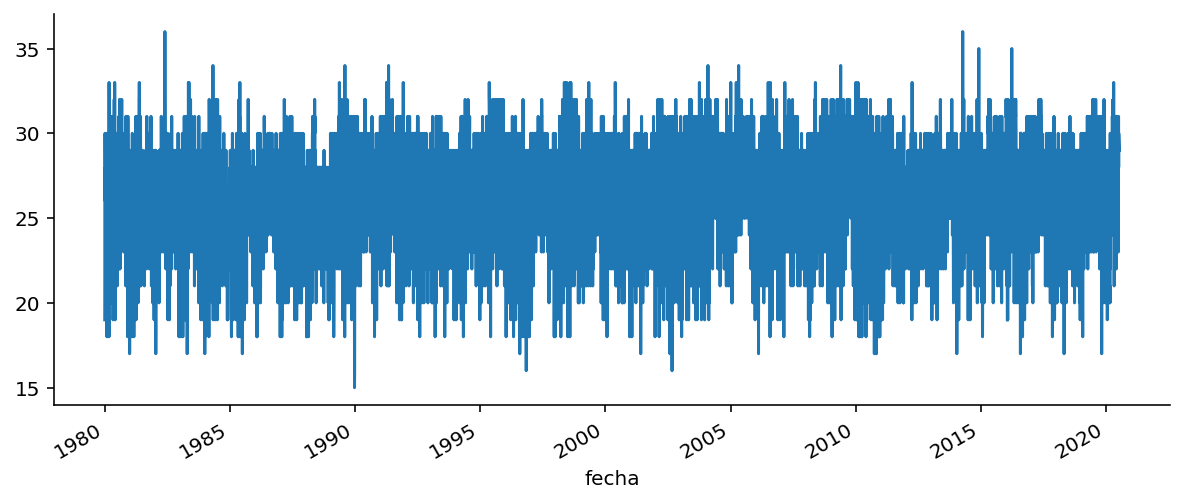

In [14]:
weather["temp_media"].plot()

## Analizando la temperatura media semanal

In [15]:
# Agrupamos los datos semanalmente y calculamos su promedio
temp_media = weather["temp_media"].resample("W").mean()
# Partimos los datos entre datos de entrenamiento y datos de prueba (train / test)
# 70/80 entrenamiento || 30 / 20 de prueba
temp_media_train, temp_media_test = temp_media[:"2019"], temp_media["2020":]

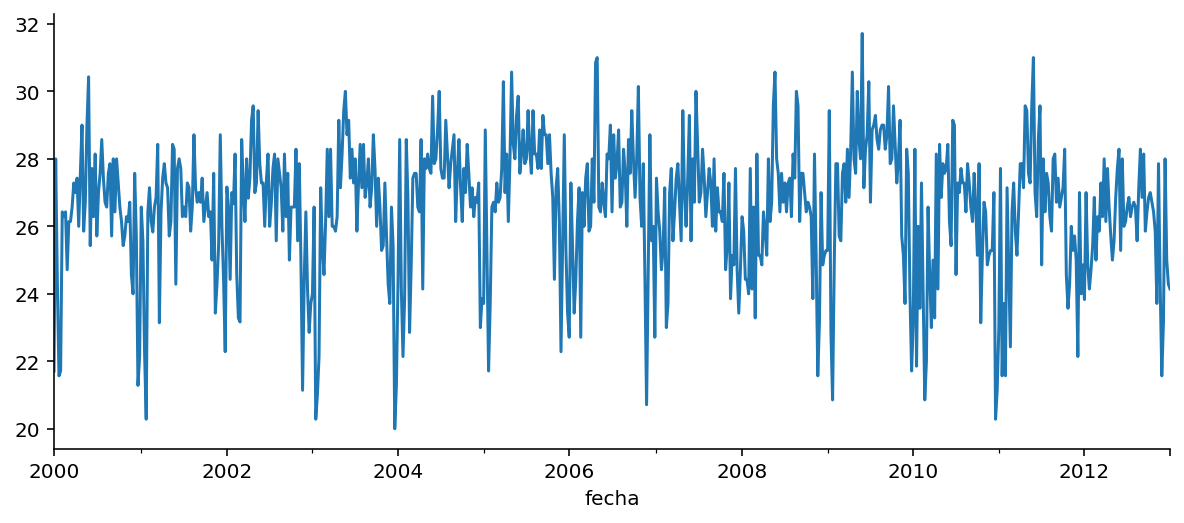

In [16]:
temp_media["2000":"2012"].plot()

## Autocorrelación

$$
    \text{Corr}(S_t, S_{t-\tau})
$$

In [17]:
lagged_ts = ts_utils.ts_supervised(pd.DataFrame(temp_media), n_in=52)

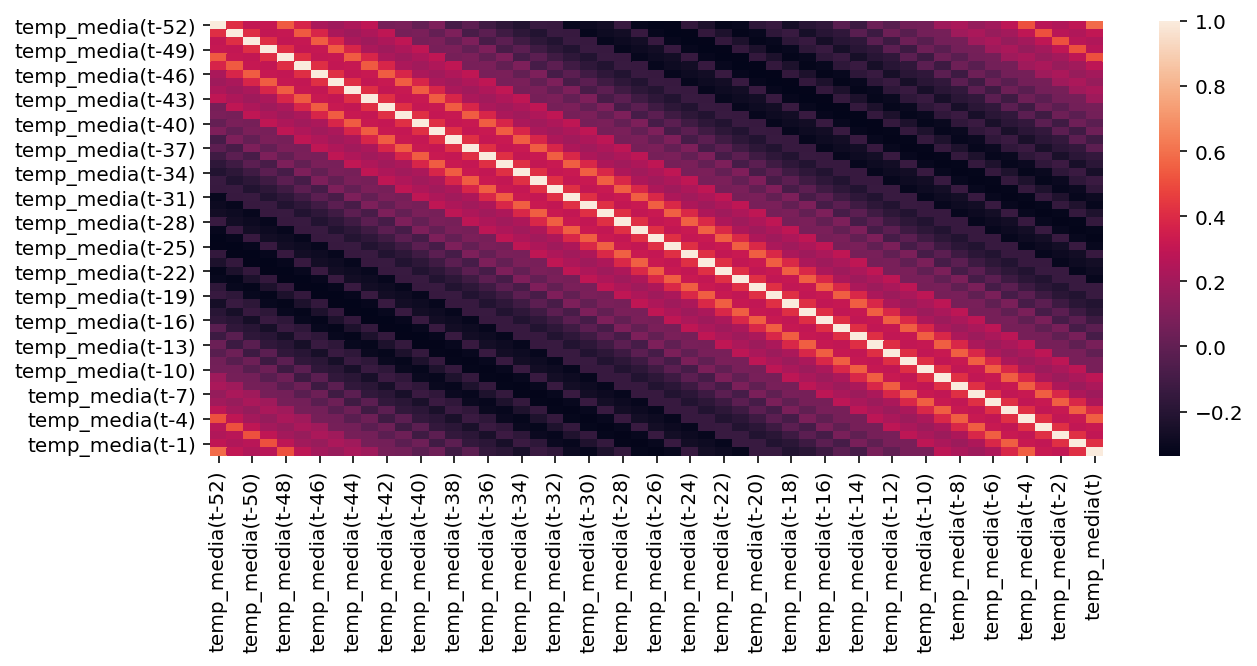

In [18]:
sns.heatmap(lagged_ts.corr());

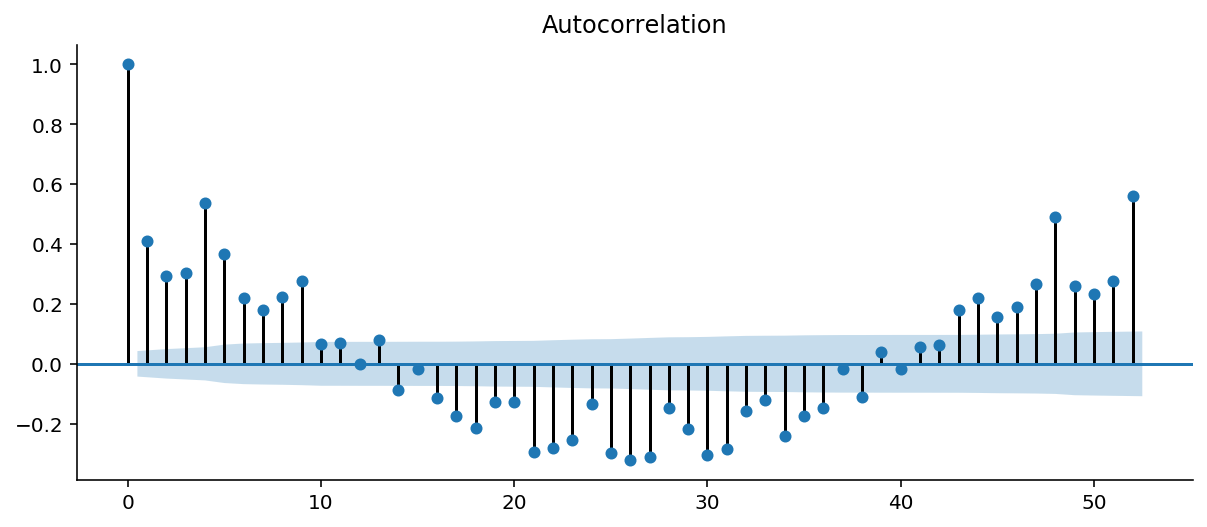

In [19]:
# Grafica de la autocorrelación
plot_acf(temp_media.ffill(), lags=52);

In [20]:
corr_min = lagged_ts.corr()["temp_media(t)"].idxmin()
corr_max = lagged_ts.corr()["temp_media(t)"][:-1].idxmax()

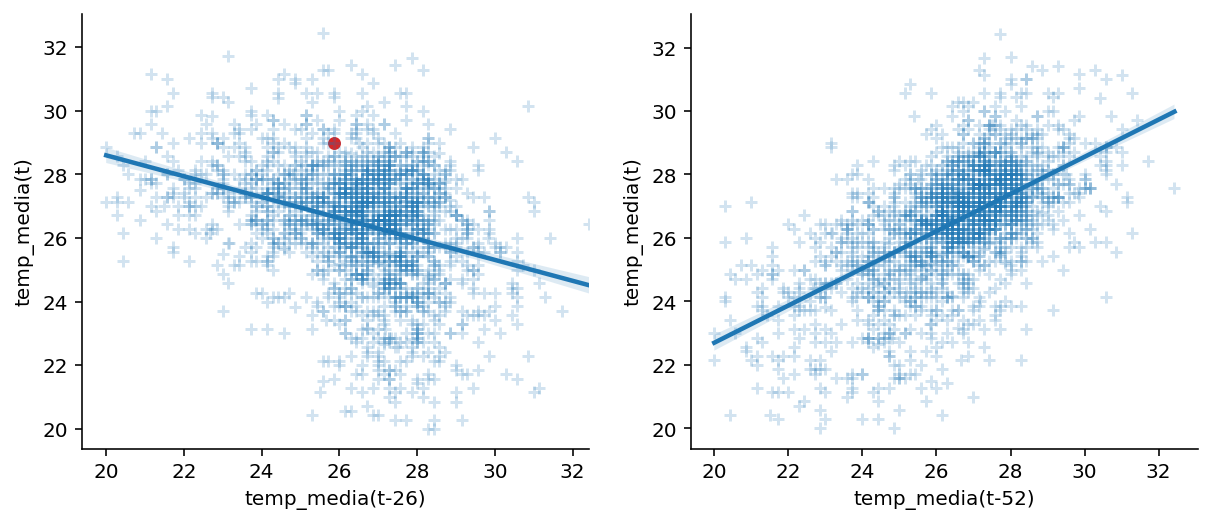

In [21]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(*lagged_ts[[corr_min, "temp_media(t)"]].iloc[-1], c="tab:red", s=30)
sns.regplot(x=corr_min, y="temp_media(t)", data=lagged_ts, scatter_kws={"alpha": 0.2}, marker="+", ax=ax[0])
sns.regplot(x=corr_max, y="temp_media(t)", data=lagged_ts, scatter_kws={"alpha": 0.2}, marker="+", ax=ax[1])

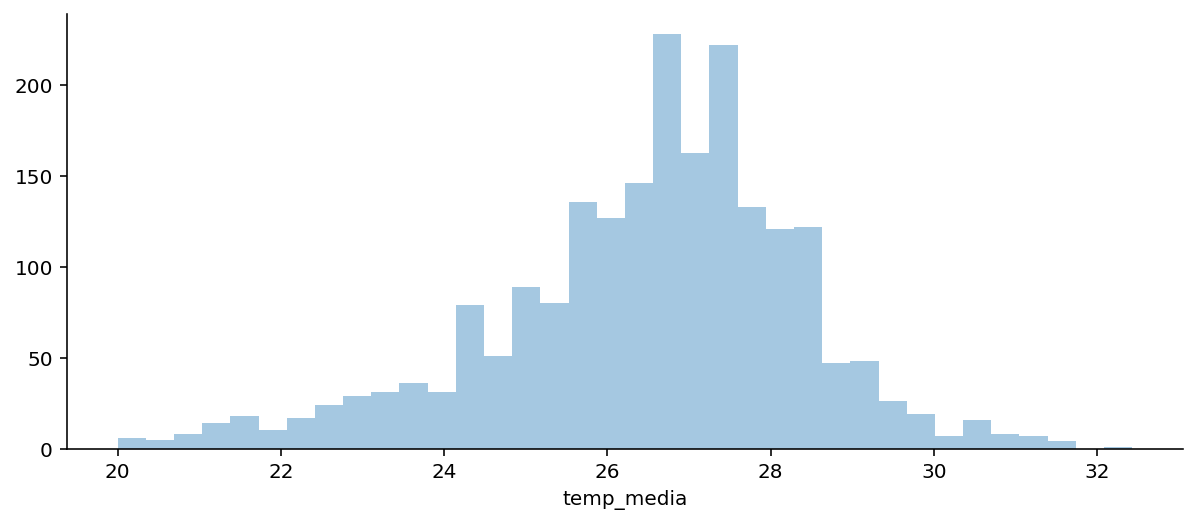

In [22]:
sns.distplot(temp_media, kde=False);

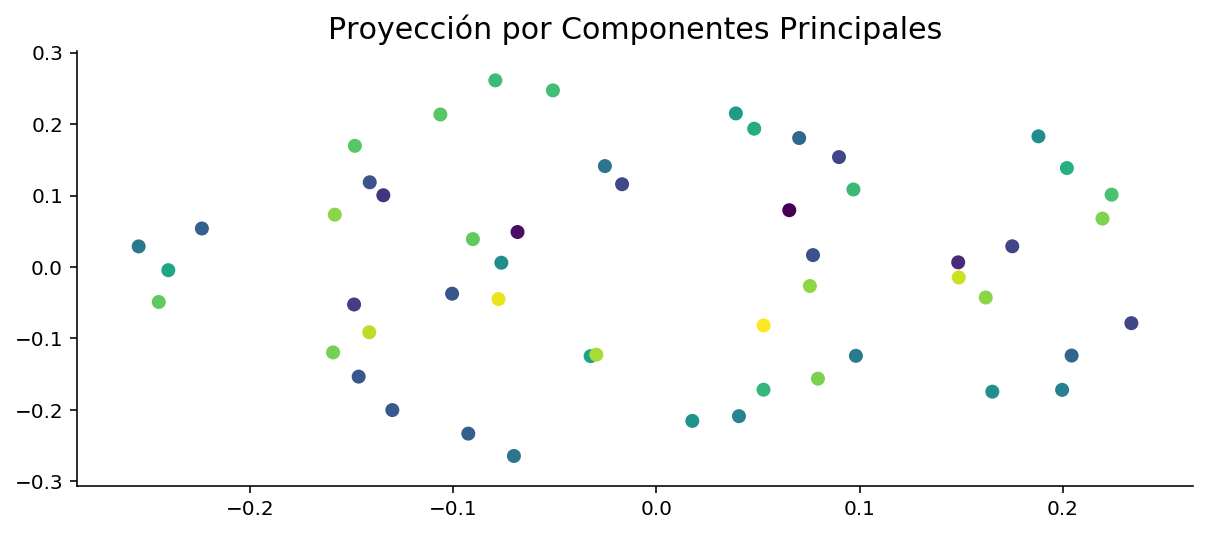

In [23]:
eigvals, eigvecs = np.linalg.eigh(np.cov(lagged_ts.T))
plt.title("Proyección por Componentes Principales", fontsize=15)
plt.scatter(*eigvecs[:, :2].T, c=eigvecs[:, 2]);

In [24]:
def monthy_temp(df, year, col, name=None):
    df_mod = df.loc[year, col].resample("M").mean()
    df_mod.index = df_mod.index.strftime("%B")
    if name is not None:
        df_mod.name = name
    return df_mod

tmean = [monthy_temp(weather, str(y), "temp_media", y) for y in range(1980, 2021)]
tmean = pd.concat(tmean, axis=1)

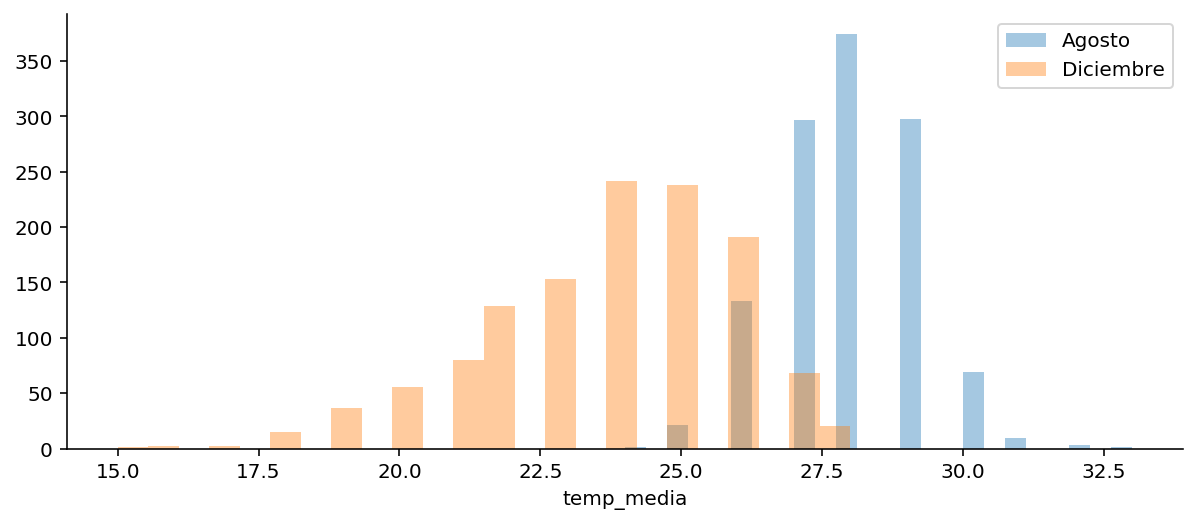

In [25]:
sns.distplot(weather.query("mes == 8")["temp_media"], kde=False, label="Agosto")
sns.distplot(weather.query("mes == 12")["temp_media"], kde=False, label="Diciembre")
plt.legend();

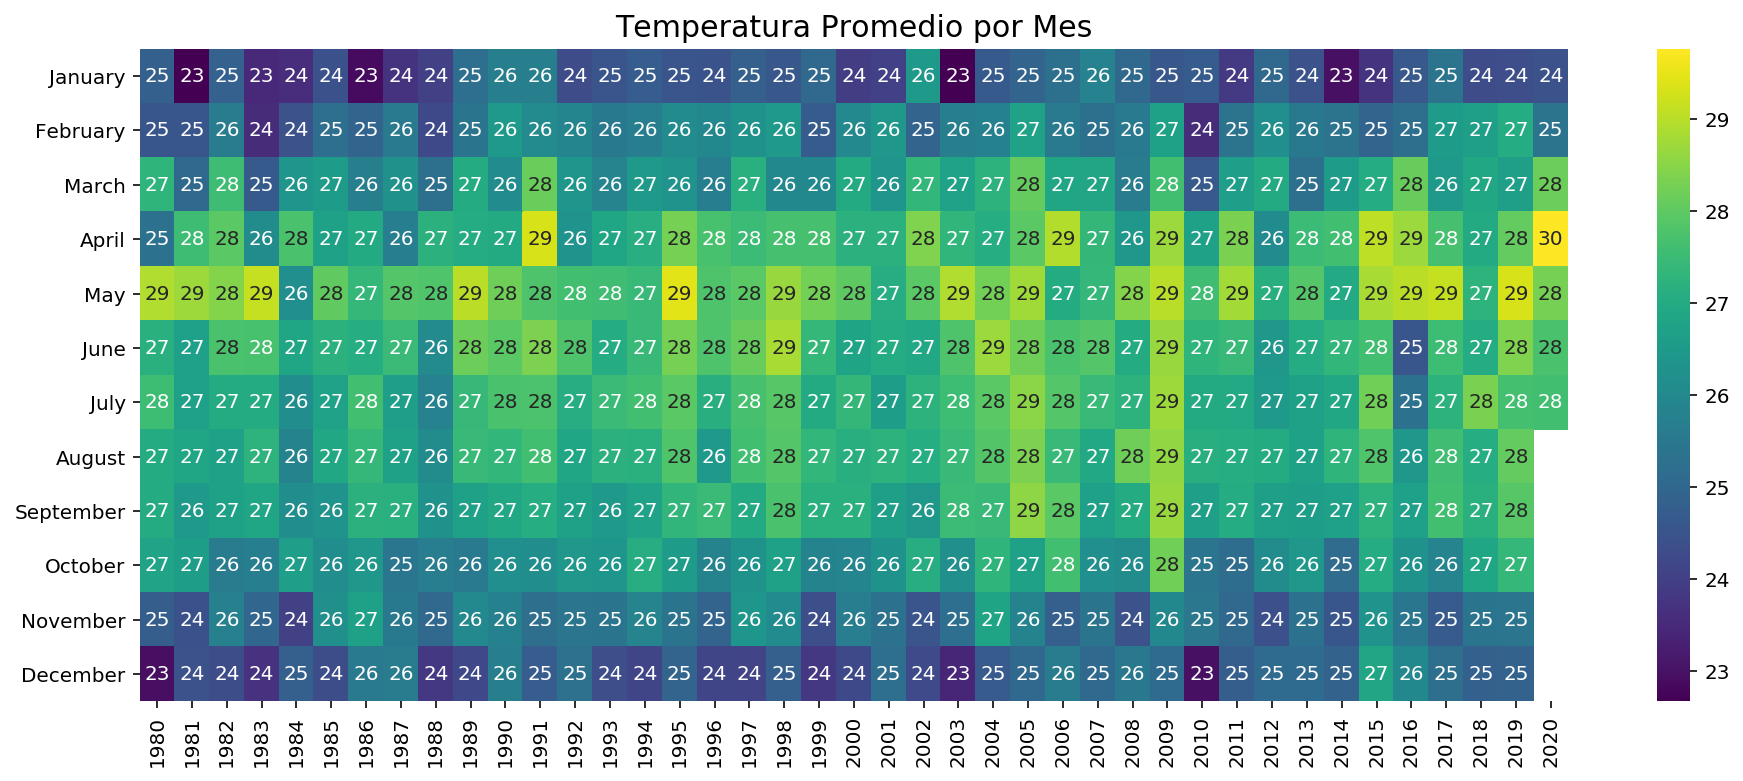

In [26]:
plt.figure(figsize=(16, 6))
plt.title("Temperatura Promedio por Mes", fontsize=15)
sns.heatmap(tmean, annot=True, cmap="viridis");

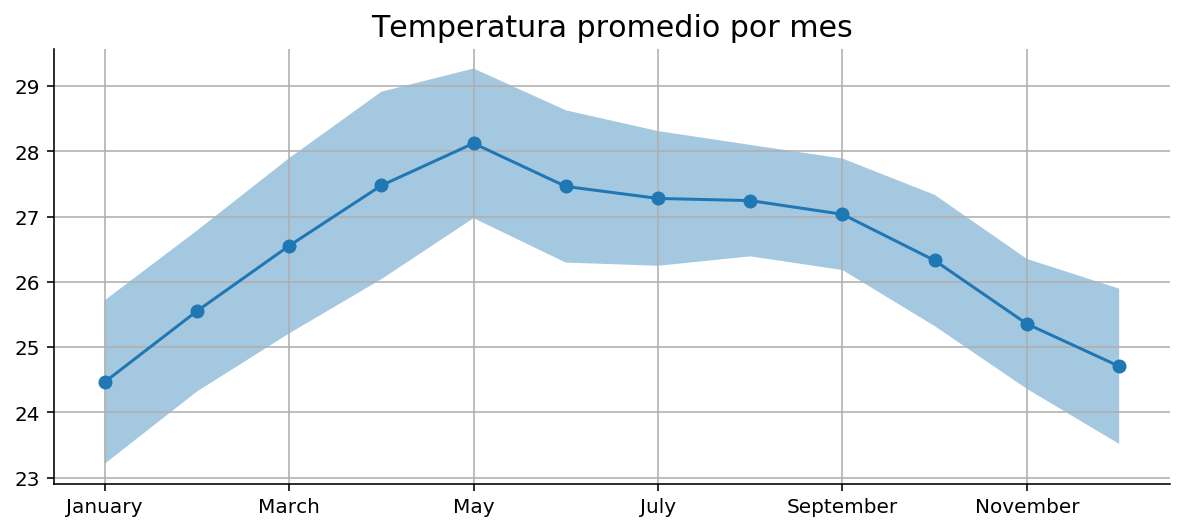

In [27]:
mu_temp = tmean.mean(axis=1)
std_temp = tmean.std(axis=1)

plt.title("Temperatura promedio por mes", fontsize=15)
mu_temp.plot(marker="o")
plt.fill_between(tmean.index, mu_temp + 1.5 * std_temp, mu_temp - 1.5 * std_temp, alpha=0.4)
plt.grid()

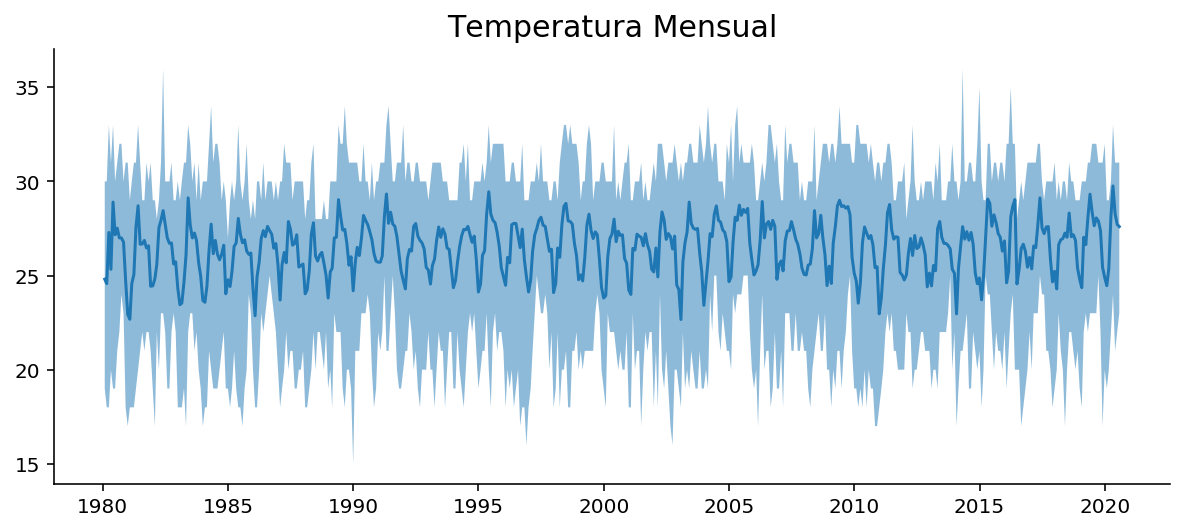

In [28]:
temp_year = weather["temp_media"].resample("M").agg(["max", "min", "mean"])

plt.title("Temperatura Mensual", fontsize=15)
plt.plot(temp_year.index, temp_year["mean"])
plt.fill_between(temp_year.index, temp_year["max"], temp_year["min"], alpha=0.5);

## La prueba de ADF (Augmented Dickey Fuller)

In [29]:
from statsmodels.tsa.stattools import adfuller

$$
    \Delta S_t = \alpha + \beta t + \gamma S_{t-1} + \sum_{\tau=1}^p \delta_{\tau}\Delta S_{t-\tau} + \epsilon_t
$$

$$
    H_0: \gamma = 0\\
    H_1: \gamma < 0
$$

In [30]:
# regression = "c" => beta = 0
adf, pval, used_lags, nobs, critical_vals, icbest = adfuller(temp_media.ffill().values, 52, regression="c")

In [31]:
pval

0.016056847389719152

# AR(1)

$$
    S_t \vert S_{t-1} \sim \mathcal{N}\left(\phi S_{t-1} + \psi, \sigma^2\right)
$$

Estimamos $\phi$, $\psi$, $\sigma^2$ por máxima verosimilitud

$$
    \hat\sigma^2 = \frac{1}{T}\left[(1 - \phi^2)\left(S_1 - \frac{\psi}{1 - \phi}\right)^2 + \sum_{t=2}^T(S_t - \phi S_{t-1} - \psi)^2\right]
$$

$$
    \log p({\bf S}\vert \psi, \phi) = \frac{1}{2}\log(1 - \phi^2) - \frac{T}{2}\log \hat\sigma^2 - \frac{T}{2}
$$

In [32]:
def get_sigma2_ml(phi, psi, S):
    mu = psi / (1 - phi)
    S1 = S.iloc[0] - mu
    T = len(S)
    S_offset = ts_utils.ts_supervised(pd.DataFrame(S))
    
    dispertion = np.sum((S_offset.iloc[:, 1] - phi * S_offset.iloc[:, 0] - psi) ** 2)
    sigma2_ml = ((1 - phi ** 2) * S1 ** 2 + dispertion) / T
    
    return sigma2_ml

def AR1(phi, psi, S):
    T = len(S)    
    sigma2_ml = get_sigma2_ml(phi, psi, S)
    
    log_likelihood = np.log(1 - phi ** 2) / 2 - T * np.log(sigma2_ml) / 2
    
    return -log_likelihood / 100

In [33]:
temp_media_train = temp_media[:"2019"]
temp_media_test = temp_media["2020"]

In [34]:
phi0, psi0 = 0, 0


f = minimize(lambda x: AR1(x[0], x[1], temp_media_train.ffill()),
             (phi0, psi0),
              method="L-BFGS-B")

f

      fun: 11.392122118664897
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.77635684e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 18
   status: 0
  success: True
        x: array([ 0.40782567, 15.67052931])

In [35]:
phi, psi = f.x

In [36]:
# E[St]
psi / (1 - phi)

26.4626961597141

In [37]:
phi

0.40782567225931216

### Ocupando una librería

In [38]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(temp_media_train.ffill(), (1, 0))
ar1 = ar1.fit(start_start=(0, 0))
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             temp_media   No. Observations:                 2087
Model:                     ARMA(1, 0)   Log Likelihood               -4100.537
Method:                       css-mle   S.D. of innovations              1.726
Date:                Thu, 30 Jul 2020   AIC                           8207.074
Time:                        17:41:38   BIC                           8224.004
Sample:                    01-06-1980   HQIC                          8213.277
                         - 12-29-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               26.4627      0.064    414.897      0.000      26.338      26.588
ar.L1.temp_media     0.4078      0.020     20.369      0.000       0.369       0.447
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4520           +0.0000j            2.4520            0.0000
-----------------------------------------------------------------------------
"""

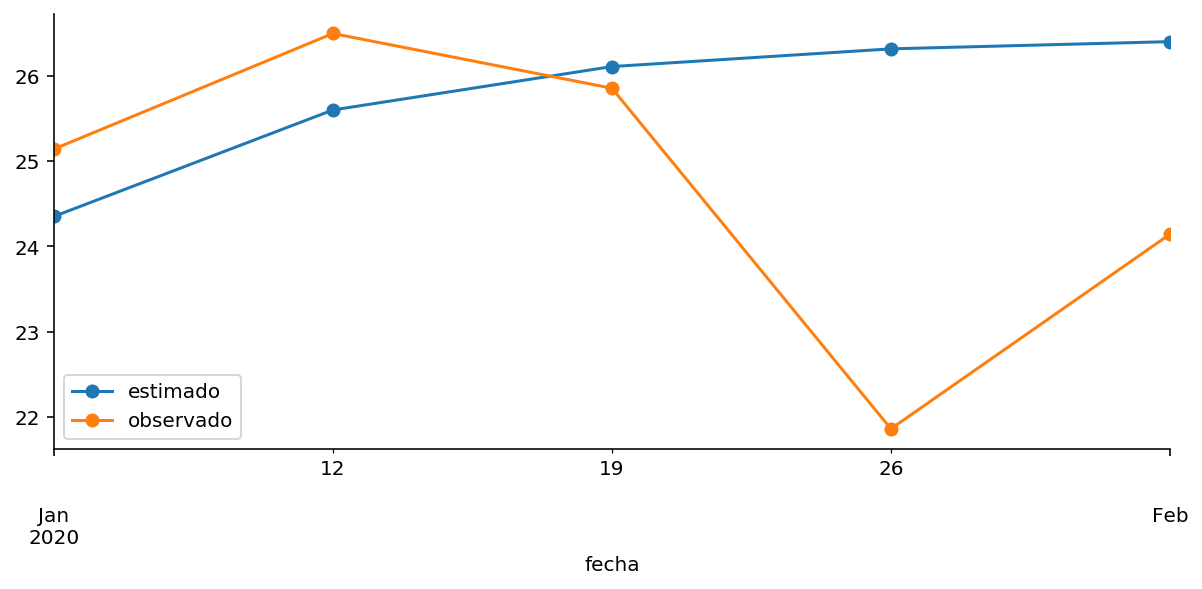

In [39]:
init_date = "2020-01-01"
end_date = "2020-02-02"


ar1.predict(start=init_date, end=end_date).plot(marker="o", label="estimado")
temp_media_test[:end_date].plot(marker="o", label="observado")
plt.legend()

* BIC (Bayes Information Criterion)
* Cross Validation

## AR(p)

$$
    S_t \vert S_{t-1}, \ldots, S_{t-p} \sim \mathcal{N}\left(\psi + \sum_{\tau=1}^p \phi_\tau S_{t - \tau}, \sigma^2\right)
$$

In [40]:
init_date = temp_media_test.index[0]
end_date = temp_media_test.index[-1]

In [42]:
list_bic = []
list_mae = []

best_bic, best_bic_mae, best_model = np.inf, None, None

ar_params =  np.arange(1, 25)
for p in tqdm(ar_params):
    arma = ARMA(temp_media_train.ffill(), (p, 0)).fit()
    bic = arma.bic
    
    temp_est = arma.predict(init_date, end_date)
    # MAE: Mean Absolute Error
    mae = pd.concat([temp_media_test, temp_est], axis=1).diff(axis=1)[0].abs().mean()
    
    if bic < best_bic:
        best_model = arma
        best_bic_mae = mae
    
    list_bic.append(bic)
    list_mae.append(mae)

* Definición / por qué de la series de tiempo
* Regresiones: Por qué es importante entender las suposiciones del modelo
* Repaso de estadística
* modelabamos $r_t$, asumiamos que i.i.d. $\implies$ independientes del tiempo
* AR: Combinación lineal de observaciones anteriores
* BIC, AIC (Creiterios de información) / Backtesting (Cross-validation)

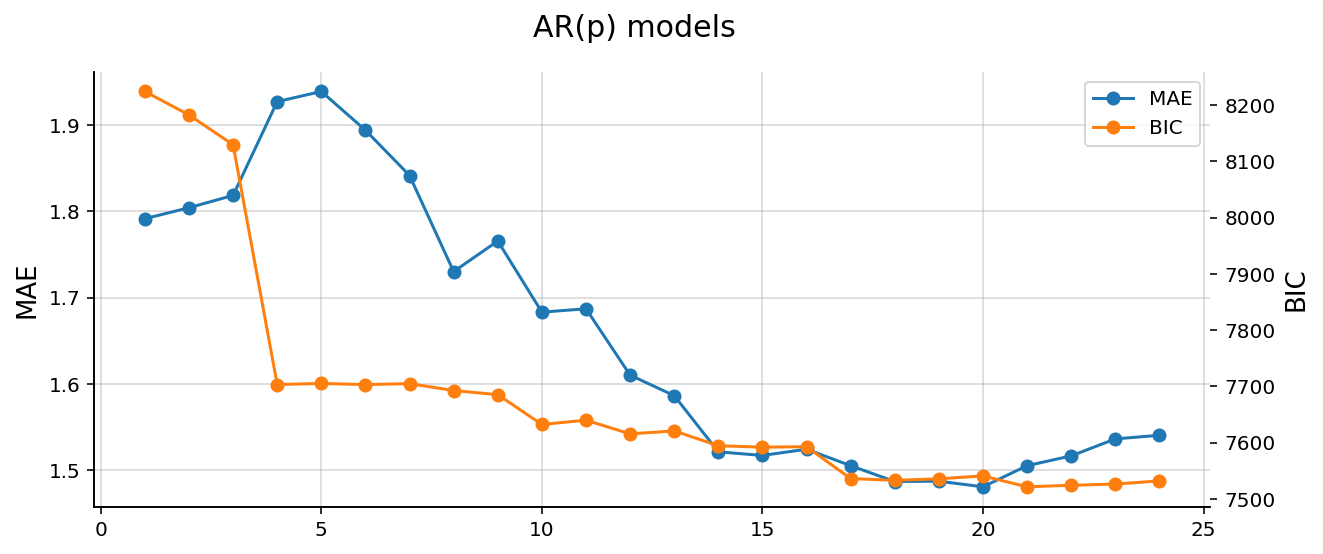

In [56]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

l1 = ax.plot(ar_params, list_mae, marker="o", label="MAE")
l2 = ax2.plot(ar_params, list_bic, marker="o", label="BIC", c="tab:orange")

values = l1 + l2
labels = [l.get_label() for l in values]
plt.legend(values, labels)

ax.set_ylabel("MAE", fontsize=13)
ax2.set_ylabel("BIC", fontsize=13)
plt.suptitle("AR(p) models", fontsize=15)
ax.grid(alpha=0.5)

In [52]:
best_bic_model = ar_params[np.argmin(list_bic)]
best_backtest_model = ar_params[np.argmin(list_mae)]

In [53]:
print(f"p bic: {best_bic_model}")
print(f"p backtest: {best_backtest_model}")

p bic: 21
p backtest: 20


In [54]:
print(f"MAE AR({best_bic_model}): {best_bic_mae:0.2f}")

MAE AR(21): 1.54


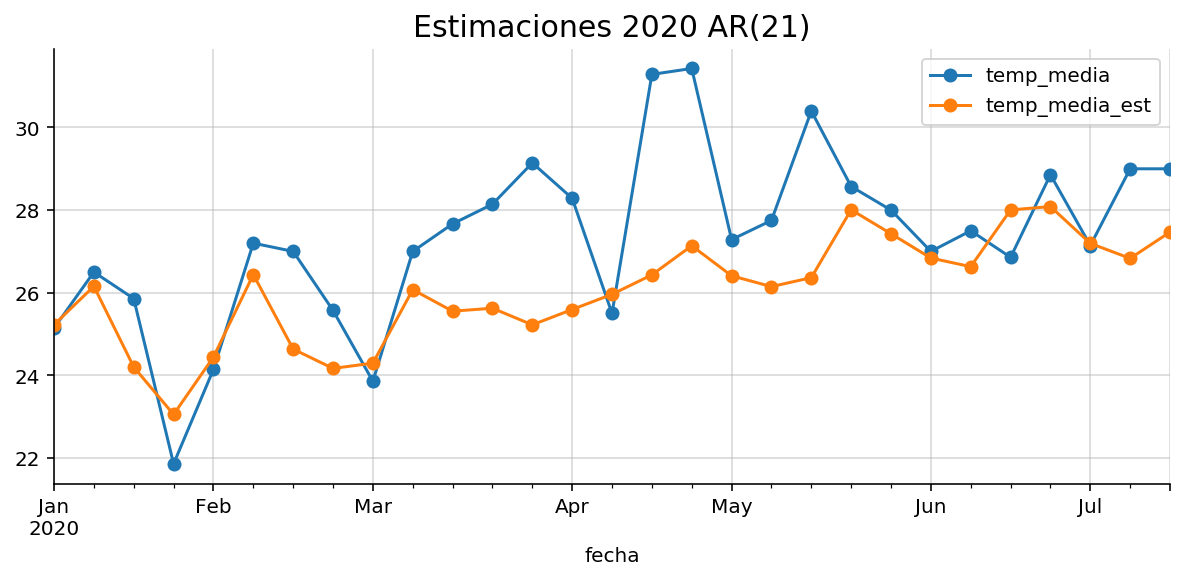

In [55]:
yhat = best_model.predict(init_date, end_date)
pd.concat([temp_media_test, yhat], axis=1)
pd.DataFrame({
    "temp_media": temp_media_test,
    "temp_media_est": yhat
}).plot(marker="o")
plt.title(f"Estimaciones 2020 AR({best_bic_model})", fontsize=15)
plt.grid(alpha=0.5)

# MA

In [59]:
from numpy.random import randn

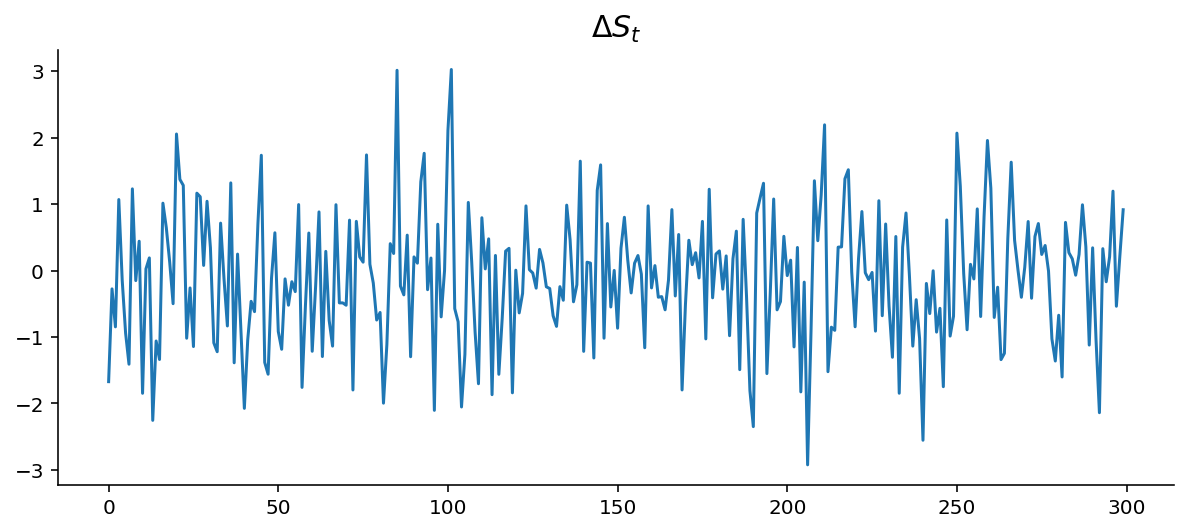

In [71]:
delta_st = randn(300) # ~ N(0, 1)
plt.title(r"$\Delta S_t$", fontsize=15)
plt.plot(delta_st);

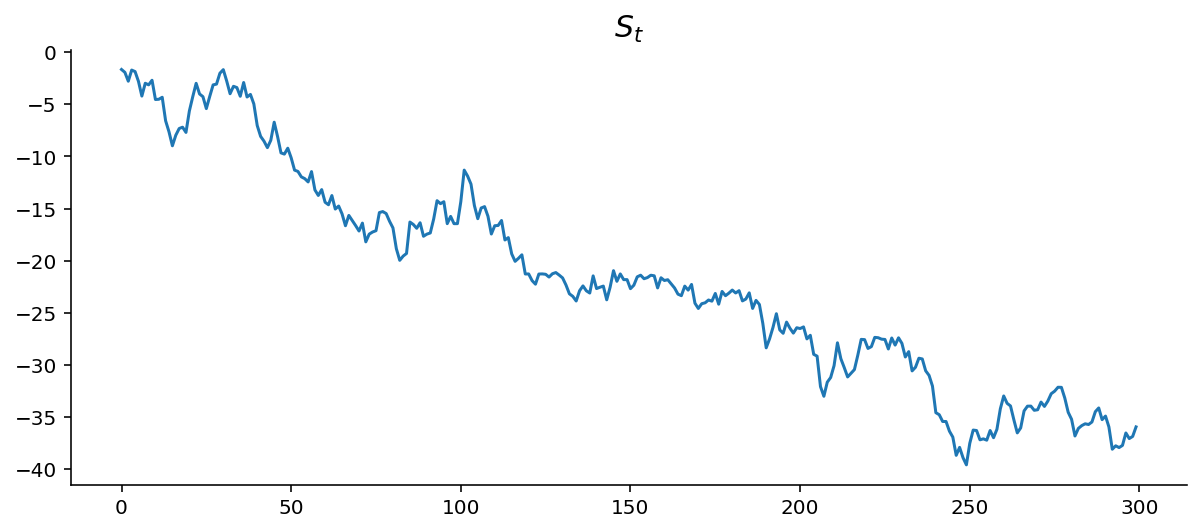

In [72]:
plt.title(r"$S_t$", fontsize=15)
plt.plot(np.cumsum(delta_st));